In [1]:
import pandas as pd
import numpy as np
import os
import csv
from zipfile import ZipFile
import torch
from scipy.stats import spearmanr
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from transformers import AutoTokenizer, XLMRobertaModel
from typing import Dict, List, Tuple, Optional
import logging
import matplotlib.pyplot as plt
import seaborn as sns
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import spearmanr

In [2]:
class DataLoaders:
    def __init__(self):
        self.setup_paths()
        self.setup_logging()

    def setup_logging(self):
        logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
        self.logger = logging.getLogger(__name__)

    def setup_paths(self):
        self.path_dev = 'dev/'
        self.path_train = 'train/'
        self.path_output = 'answer/'
        self.path_test = 'test/'

        for path in [self.path_dev, self.path_train, self.path_test, self.path_output]:
            if not os.path.exists(path):
                os.makedirs(path)

    def extract_zip_files(self):
        # Extract dev.zip
        if not os.listdir(self.path_dev):
            with ZipFile('dev.zip', 'r') as dev:
                dev.extractall(self.path_dev)

        # Extract train.zip
        if not os.listdir(self.path_train):
            with ZipFile('train.zip', 'r') as train:
                train.extractall(self.path_train)

        if not os.listdir(self.path_test):
            with ZipFile('test.zip', 'r') as test:
                test.extractall(self.path_test)

    def load_tsv_files(self):
        languages = os.listdir(self.path_train)
        self.logger.info(f"Found languages: {languages}")

        # Initialize file paths
        label_file_paths_train = []
        uses_file_paths_train = []
        label_file_paths_dev = []
        instance_file_paths_dev = []
        uses_file_paths_dev = []
        instance_file_paths_test = []
        uses_file_paths_test = []


        for lang in languages:
            label_file_paths_train.append(f"{self.path_train}{lang}/labels.tsv")
            uses_file_paths_train.append(f"{self.path_train}{lang}/uses.tsv")
            label_file_paths_dev.append(f"{self.path_dev}{lang}/labels.tsv")
            instance_file_paths_dev.append(f"{self.path_dev}{lang}/instances.tsv")
            uses_file_paths_dev.append(f"{self.path_dev}{lang}/uses.tsv")
            instance_file_paths_test.append(f"{self.path_test}{lang}/instances.tsv")
            uses_file_paths_test.append(f"{self.path_test}{lang}/uses.tsv")

        paths = {
            'train_labels_list': label_file_paths_train,
            'train_uses_list': uses_file_paths_train,
            'dev_labels_list': label_file_paths_dev,
            'dev_uses_list': uses_file_paths_dev,
            'dev_instances_list': instance_file_paths_dev,
            'test_uses_list': uses_file_paths_test,
            'test_instances_list': instance_file_paths_test
        }

        data_dict = {key: [] for key in paths.keys()}

        for save_path, path_list in paths.items():
            for path in path_list:
                with open(path, encoding='utf-8') as tsvfile:
                    language = path.split('/')[1]
                    reader = csv.DictReader(tsvfile, delimiter='\t',
                                         quoting=csv.QUOTE_MINIMAL, quotechar='"')
                    for row in reader:
                        row['language'] = language
                        data_dict[save_path].append(row)

        return data_dict

    def create_merged_dataframes(self, data_dict):
        def create_mappings(uses_list):
            id2context = {}
            id2idx = {}
            for row in uses_list:
                identifier = row['identifier']
                id2context[identifier] = row['context']
                id2idx[identifier] = row['indices_target_token']
            return id2context, id2idx

        # Create mappings
        train_id2context, train_id2idx = create_mappings(data_dict['train_uses_list'])
        dev_id2context, dev_id2idx = create_mappings(data_dict['dev_uses_list'])
        test_id2context, test_id2idx = create_mappings(data_dict['test_uses_list'])

        # Merge train data
        train_uses_merged = []
        for row in data_dict['train_labels_list']:
            identifier1_train = row['identifier1']
            identifier2_train = row['identifier2']

            data_row = {
                'context1': train_id2context.get(identifier1_train),
                'context2': train_id2context.get(identifier2_train),
                'index_target_token1': train_id2idx.get(identifier1_train),
                'index_target_token2': train_id2idx.get(identifier2_train),
                'identifier1': identifier1_train,
                'identifier2': identifier2_train,
                'lemma': row['lemma'],
                'mean_disagreement_cleaned': row['mean_disagreement_cleaned'],
                'judgments': row['judgments'],
                'language': row['language']
            }
            train_uses_merged.append(data_row)

        # Merge dev data
        dev_uses_merged = []
        for row in data_dict['dev_labels_list']:
            identifier1_dev = row['identifier1']
            identifier2_dev = row['identifier2']

            data_row = {
                'context1': dev_id2context.get(identifier1_dev),
                'context2': dev_id2context.get(identifier2_dev),
                'index_target_token1': dev_id2idx.get(identifier1_dev),
                'index_target_token2': dev_id2idx.get(identifier2_dev),
                'identifier1': identifier1_dev,
                'identifier2': identifier2_dev,
                'lemma': row['lemma'],
                'mean_disagreement_cleaned': row['mean_disagreement_cleaned'],
                'judgments': row['judgments'],
                'language': row['language']
            }
            dev_uses_merged.append(data_row)

        test_uses_merged = []
        for row in data_dict['test_instances_list']:
            identifier1_test = row['identifier1']
            identifier2_test = row['identifier2']

            data_row = {
                'context1': test_id2context.get(identifier1_test),
                'context2': test_id2context.get(identifier2_test),
                'index_target_token1': test_id2idx.get(identifier1_test),
                'index_target_token2': test_id2idx.get(identifier2_test),
                'identifier1': identifier1_test,
                'identifier2': identifier2_test,
                'lemma': row['lemma'],
                'language': row['language']
            }
            test_uses_merged.append(data_row)

        return pd.DataFrame(train_uses_merged), pd.DataFrame(dev_uses_merged), pd.DataFrame(test_uses_merged)

In [4]:
data_loader = DataLoaders()
data_loader.extract_zip_files()
data_dict = data_loader.load_tsv_files()
df_train_uses_merged, df_dev_uses_merged, df_test_uses_merged= data_loader.create_merged_dataframes(data_dict)

2024-11-17 12:39:27,526 - INFO - Found languages: ['chinese', 'spanish', 'german', 'norwegian', 'english', 'swedish', 'russian']


In [5]:
display(df_train_uses_merged.head())
display(df_dev_uses_merged.head())
display(df_test_uses_merged.head())

,context1,context2,index_target_token1,index_target_token2,identifier1,identifier2,lemma,mean_disagreement_cleaned,judgments,language
0,在大寨人自力更生建设山区革命精神的鼓舞下，他们下海围田，上山开荒，与自然奋战，向天公争粮,我一大早跑到了海边，沙滩上多了几条大木船，那是渔民下海夜里归来的吧,23:25,25:27,1966-14-12,1994-73-12,下海,0.0,"[3, 3]",chinese
1,”他瞅了瞅他现在穿的新皮大氅，又说：“过去我下海、在家，总是穿一件又腥又破的棉短袄；吃呢，一...,近年来，该报围绕“科技成果的评审和鉴定”、“上山与下海”、“科学研究如何选优和评价”等热点问...,22:24,25:27,1958-26-12,1994-53-12,下海,0.0,"[2, 2]",chinese
2,”他瞅了瞅他现在穿的新皮大氅，又说：“过去我下海、在家，总是穿一件又腥又破的棉短袄；吃呢，一...,我校乔刚同学在习作中给老师的信委婉地揭示出当前教师“下海”的现实，表达了学生对老师的依恋之情...,22:24,26:28,1958-26-12,1993-92-12,下海,1.0,"[2, 1]",chinese
3,驻守在沿海和海岛上的部队一面严密搜索海上敌情，保卫渔民生产，一面下海撒网捕捞鱼虾或在海边种海...,我们的老二，也就在这时候下定决心申请离职“下海”经商了,32:34,21:23,1961-42-12,1994-82-12,下海,0.0,"[2, 2]",chinese
4,驻守在沿海和海岛上的部队一面严密搜索海上敌情，保卫渔民生产，一面下海撒网捕捞鱼虾或在海边种海...,我一大早跑到了海边，沙滩上多了几条大木船，那是渔民下海夜里归来的吧,32:34,25:27,1961-42-12,1994-73-12,下海,0.0,"[4, 4]",chinese


,context1,context2,index_target_token1,index_target_token2,identifier1,identifier2,lemma,mean_disagreement_cleaned,judgments,language
0,为把假货拒之门外，济南国有商店规范经营活动，把打假防假工作作为企业生存、发展的根本，落实责任...,在努力帮助“农民长期得实惠”的同时，唐山市也积极探索让“干部长期受教育”的机制,50:52,37:39,1996-98-26,2002-79-26,机制,0.0,"[4, 4]",chinese
1,例如，疗效需要进一步巩固和提高，方法有待于进一步丰富和发展，机制理论的研究有待于进一步加强，...,目前一方面在深入研究传染性肝炎发病机制，另一方面已把这些总结出来的经验推广到全市,30:32,17:19,1960-37-26,1960-44-26,机制,2.0,"[4, 2]",chinese
2,其中《五十例阴虚患者症候分类分析及病理机制与治疗规律的探讨》、《对传染性肝炎的认识和探讨》等...,《条例》对公务员的录用、考核、升降、进出、监督、回避、轮换等都作出了明确的法令性的规定，有利...,19:21,61:63,1961-6-26,1993-65-26,机制,2.0,"[4, 2]",chinese
3,为把假货拒之门外，济南国有商店规范经营活动，把打假防假工作作为企业生存、发展的根本，落实责任...,由于各地党政领导重视创安工作，从人防、物防、技防上进一步强化了社区治安防范机制，预防和控制犯...,50:52,37:39,1996-98-26,1997-93-26,机制,0.0,"[4, 4]",chinese
4,为把假货拒之门外，济南国有商店规范经营活动，把打假防假工作作为企业生存、发展的根本，落实责任...,温州机制活，民间资金丰富，国内外市场渠道畅通，在目前市场疲软、资金短缺的情况下应该发挥优势，...,50:52,2:4,1996-98-26,1998-88-26,机制,0.0,"[1, 1]",chinese


,context1,context2,index_target_token1,index_target_token2,identifier1,identifier2,lemma,language
0,在运动中，几百万商业职工在商品的收购、包装、运输、装卸、搬运、保管、销售等各个环节上，费尽心...,在全国十二个中型氮肥厂中，生产能力提高最快，能源消耗最少，成本最低，利润最多，化肥包装质量最...,19:21,41:43,1964-16-30,1979-91-30,包装,chinese
1,在运动中，几百万商业职工在商品的收购、包装、运输、装卸、搬运、保管、销售等各个环节上，费尽心...,有些产品的质量、花色品种和包装装潢，与国际市场上同类产品相比，差距很大,19:21,13:15,1964-16-30,1978-5-30,包装,chinese
2,在运动中，几百万商业职工在商品的收购、包装、运输、装卸、搬运、保管、销售等各个环节上，费尽心...,如天津市调往外地的自行车，由于包装不好，每年报损二百四十多万元；北京市外调和市销的大瓶雪花膏...,19:21,15:17,1964-16-30,1978-40-30,包装,chinese
3,在运动中，几百万商业职工在商品的收购、包装、运输、装卸、搬运、保管、销售等各个环节上，费尽心...,要认真搞好产品的包装，货运部门的职工要增强责任感，减少装卸、运输过程中的损失,19:21,8:10,1964-16-30,1978-4-30,包装,chinese
4,在运动中，几百万商业职工在商品的收购、包装、运输、装卸、搬运、保管、销售等各个环节上，费尽心...,人们记得，最近几年来，苏联外长葛罗米柯年复一年在联大提出的“重要而紧急”的议题，都是那些换了...,19:21,47:49,1964-16-30,1977-8-30,包装,chinese


In [6]:
class EmbeddingGenerator:
    def __init__(self, model_name="FacebookAI/xlm-roberta-base"):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = XLMRobertaModel.from_pretrained(model_name)

    def truncation_indices(self, target_subword_indices, truncation_tokens_before_target=0.5):
        max_tokens = 512
        n_target_subtokens = target_subword_indices.count(True)
        tokens_before = int((max_tokens - n_target_subtokens) * truncation_tokens_before_target)
        tokens_after = max_tokens - tokens_before - n_target_subtokens

        lindex_target = target_subword_indices.index(True)
        rindex_target = lindex_target + n_target_subtokens
        lindex = max(lindex_target - tokens_before, 0)
        rindex = rindex_target + tokens_after

        return lindex, rindex

    def get_target_token_embedding(self, context, index):
        start_idx = int(str(index).strip().split(':')[0])
        end_idx = int(str(index).strip().split(':')[1])

        inputs = self.tokenizer(context, return_tensors="pt",
                              return_offsets_mapping=True, add_special_tokens=False)

        offset_mapping = inputs['offset_mapping'][0].tolist()
        input_ids = inputs['input_ids']
        tokens = self.tokenizer.convert_ids_to_tokens(input_ids[0])

        subwords_bool_mask = [
            (start <= start_idx < end) or (start < end_idx <= end)
            or (start_idx <= start and end <= end_idx)
            for start, end in offset_mapping
        ]

        if len(input_ids[0]) > 512:
            lindex, rindex = self.truncation_indices(subwords_bool_mask)
            tokens = tokens[lindex:rindex]
            input_ids = input_ids[:, lindex:rindex]
            subwords_bool_mask = subwords_bool_mask[lindex:rindex]
            inputs['input_ids'] = input_ids

        with torch.no_grad():
            outputs = self.model(inputs['input_ids'])

        target_embeddings = outputs.last_hidden_state[0][subwords_bool_mask]
        return target_embeddings.mean(dim=0).numpy()

    def generate_embeddings(self, df, file_name):
        id2embedding = {}

        for _, row in df.iterrows():
            identifier1 = row['identifier1']
            identifier2 = row['identifier2']

            if identifier1 not in id2embedding:
                embedding1 = self.get_target_token_embedding(row['context1'],
                                                          row['index_target_token1'])
                id2embedding[identifier1] = embedding1

            if identifier2 not in id2embedding:
                embedding2 = self.get_target_token_embedding(row['context2'],
                                                          row['index_target_token2'])
                id2embedding[identifier2] = embedding2

        np.savez(file_name, **id2embedding)
        return id2embedding

In [7]:
# Generate embeddings
#embedding_generator = EmbeddingGenerator()
#train_embeddings = embedding_generator.generate_embeddings(df_train_uses_merged,
                                                         #'subtask2_train_embeddings.npz')

#dev_embeddings = embedding_generator.generate_embeddings(df_dev_uses_merged,
                                                       #'subtask2_dev_embeddings.npz')

In [8]:
class AdapterNetwork(nn.Module):
    def __init__(self, embedding_dim=768, hidden_dims=[512, 256], dropout_rate=0.2):
        super(AdapterNetwork, self).__init__()

        reduction_factor = 8
        bottleneck_dim = embedding_dim // reduction_factor

        self.adapter1 = nn.Sequential(
            nn.Linear(embedding_dim, bottleneck_dim),
            nn.LayerNorm(bottleneck_dim),
            nn.GELU(),
            nn.Dropout(dropout_rate),
            nn.Linear(bottleneck_dim, embedding_dim),
            nn.LayerNorm(embedding_dim),
            nn.Dropout(dropout_rate)
        )

        self.adapter2 = nn.Sequential(
            nn.Linear(embedding_dim, bottleneck_dim),
            nn.LayerNorm(bottleneck_dim),
            nn.GELU(),
            nn.Dropout(dropout_rate),
            nn.Linear(bottleneck_dim, embedding_dim),
            nn.LayerNorm(embedding_dim),
            nn.Dropout(dropout_rate)
        )

        # Add residual connections
        self.layer_norm1 = nn.LayerNorm(embedding_dim)
        self.layer_norm2 = nn.LayerNorm(embedding_dim)

        # Calculate input dimension for the classifier
        combined_embedding_dim = embedding_dim * 2
        feature_dim = embedding_dim * 4 + 3
        total_input_dim = combined_embedding_dim + feature_dim

        # Improved classifier with residual connections
        self.classifier_layers = nn.ModuleList()
        input_dim = total_input_dim

        for hidden_dim in hidden_dims:
            self.classifier_layers.append(nn.ModuleDict({
                'linear': nn.Linear(input_dim, hidden_dim),
                'norm': nn.LayerNorm(hidden_dim),
                'dropout': nn.Dropout(dropout_rate)
            }))
            input_dim = hidden_dim

        self.final_layer = nn.Linear(input_dim, 1)

    def forward(self, embedding1, embedding2, combined_features):
        # Apply adapters with residual connections
        adapted1 = self.layer_norm1(embedding1 + self.adapter1(embedding1))
        adapted2 = self.layer_norm2(embedding2 + self.adapter2(embedding2))

        # Concatenate adapted embeddings with combined features
        x = torch.cat([adapted1, adapted2, combined_features], dim=1)

        # Pass through classifier with residual connections where possible
        for layer in self.classifier_layers:
            residual = x if x.size(1) == layer['linear'].out_features else None
            x = layer['linear'](x)
            x = layer['norm'](x)
            x = F.gelu(x)
            if residual is not None:
                x = x + residual
            x = layer['dropout'](x)

        # Final layer
        output = self.final_layer(x)
        # Ensure output is squeezed to match target dimension
        return output.squeeze(-1)  # Changed from no arguments to -1

In [9]:
class CustomDataset(Dataset):
    def __init__(self, data, embeddings, max_len=512, is_test=False):
        self.data = data
        self.embeddings = self.load_embeddings(embeddings)
        self.max_len = max_len
        self.is_test = is_test

    def __len__(self):
        return len(self.data)

    def create_features(self, embedding1, embedding2):
        """Create combined features from two embeddings."""
        concatenated = np.concatenate([embedding1, embedding2])
        difference = embedding1 - embedding2
        product = embedding1 * embedding2

        # Calculate similarity metrics
        cos_sim = np.dot(embedding1, embedding2) / (
            np.linalg.norm(embedding1) * np.linalg.norm(embedding2) + 1e-8)
        euclidean_dist = np.linalg.norm(embedding1 - embedding2)
        manhattan_dist = np.sum(np.abs(embedding1 - embedding2))

        # Combine all features
        features = np.concatenate([
            concatenated,
            difference,
            product,
            [cos_sim, euclidean_dist, manhattan_dist]
        ])
        return torch.tensor(features, dtype=torch.float)

    def load_embeddings(self, file_name):
        """Load embeddings from a single .npz file."""
        try:
            loaded_embeddings = np.load(file_name)
            embeddings = {identifier: loaded_embeddings[identifier]
                        for identifier in loaded_embeddings.files}
            return embeddings
        except Exception as e:
            print(f"Error loading embeddings from {file_name}: {e}")
            return {}

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        identifier1 = row['identifier1']
        identifier2 = row['identifier2']

        # Get embeddings with zero padding if not found
        embedding1 = self.embeddings.get(identifier1, np.zeros(self.max_len))
        embedding2 = self.embeddings.get(identifier2, np.zeros(self.max_len))

        # Convert embeddings to tensors
        target_embedding1 = torch.tensor(embedding1, dtype=torch.float)
        target_embedding2 = torch.tensor(embedding2, dtype=torch.float)

        # Create combined features
        combined_features = self.create_features(embedding1, embedding2)

        if not self.is_test:
            # Get the median_cleaned value as a float for regression
            target = torch.tensor(float(row['mean_disagreement_cleaned']), dtype=torch.float)

            return {
                'target_embedding1': target_embedding1,
                'target_embedding2': target_embedding2,
                'combined_features': combined_features,
                'target': target
            }
        else:
            return {
                'target_embedding1': target_embedding1,
                'target_embedding2': target_embedding2,
                'combined_features': combined_features
            }


In [10]:
class AdapterLearner:
    def __init__(self,
                 embedding_dim=768,
                 hidden_dims=[512, 256],
                 learning_rate=1e-4,
                 batch_size=32,
                 num_epochs=10,
                 dropout_rate=0.2,
                 device='cuda' if torch.cuda.is_available() else 'cpu'):

        self.model = AdapterNetwork(
            embedding_dim=embedding_dim,
            hidden_dims=hidden_dims,
            dropout_rate=dropout_rate
        ).to(device)

        self.optimizer = optim.AdamW(self.model.parameters(), lr=learning_rate)
        self.criterion = nn.MSELoss(reduction='mean')
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.device = device

        self.train_losses = []
        self.val_losses = []

        # Add learning rate scheduler
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', factor=0.5, patience=2, verbose=True
        )

    def train(self, train_dataset, val_dataset=None):
        train_loader = DataLoader(
            train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            pin_memory=True if self.device == 'cuda' else False
        )

        if val_dataset:
            val_loader = DataLoader(
                val_dataset,
                batch_size=self.batch_size,
                shuffle=False,
                pin_memory=True if self.device == 'cuda' else False
            )

        best_val_loss = float('inf')

        for epoch in range(self.num_epochs):
            self.model.train()
            total_train_loss = 0
            train_batches = tqdm(train_loader, desc=f'Epoch {epoch+1}/{self.num_epochs}')

            for batch in train_batches:
                self.optimizer.zero_grad()

                embedding1 = batch['target_embedding1'].to(self.device)
                embedding2 = batch['target_embedding2'].to(self.device)
                combined_features = batch['combined_features'].to(self.device)
                # Keep targets as a 1D tensor
                targets = batch['target'].to(self.device).float()

                outputs = self.model(embedding1, embedding2, combined_features)
                loss = self.criterion(outputs, targets)

                loss.backward()
                # Add gradient clipping
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                self.optimizer.step()

                total_train_loss += loss.item()
                train_batches.set_postfix({'train_loss': loss.item()})

            avg_train_loss = total_train_loss / len(train_loader)
            self.train_losses.append(avg_train_loss)

            if val_dataset:
                val_loss = self.evaluate(val_loader)
                self.val_losses.append(val_loss)

                print(f'Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {val_loss:.4f}')

                # Update learning rate scheduler
                self.scheduler.step(val_loss)

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': self.model.state_dict(),
                        'optimizer_state_dict': self.optimizer.state_dict(),
                        'val_loss': val_loss,
                    }, 'best_adapter_model.pt')
            else:
                print(f'Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}')

        return self.train_losses, self.val_losses

    def evaluate(self, val_loader):
        self.model.eval()
        total_val_loss = 0

        with torch.no_grad():
            for batch in val_loader:
                embedding1 = batch['target_embedding1'].to(self.device)
                embedding2 = batch['target_embedding2'].to(self.device)
                combined_features = batch['combined_features'].to(self.device)
                targets = batch['target'].to(self.device).float()

                outputs = self.model(embedding1, embedding2, combined_features)
                loss = self.criterion(outputs, targets)
                total_val_loss += loss.item()

        return total_val_loss / len(val_loader)

    def predict(self, test_dataset):
        test_loader = DataLoader(
            test_dataset,
            batch_size=self.batch_size,
            shuffle=False
        )

        self.model.eval()
        predictions = []

        with torch.no_grad():
            for batch in test_loader:
                embedding1 = batch['target_embedding1'].to(self.device)
                embedding2 = batch['target_embedding2'].to(self.device)
                combined_features = batch['combined_features'].to(self.device)

                outputs = self.model(embedding1, embedding2, combined_features)
                predictions.extend(outputs.cpu().numpy())

        return np.array(predictions)

In [11]:
train_dataset = CustomDataset(data=df_train_uses_merged,
                            embeddings='subtask2_train_embeddings.npz',
                            max_len=512,
                            is_test=False)

dev_dataset = CustomDataset(data=df_dev_uses_merged,
                        embeddings='subtask2_dev_embeddings.npz',
                        max_len=512,
                        is_test=False)
test_dataset = CustomDataset(data=df_test_uses_merged,
                        embeddings='subtask2_test_embeddings.npz',
                        max_len=512,
                        is_test=True)

In [12]:
learner = AdapterLearner(
        embedding_dim=768,  # XLM-RoBERTa base embedding dimension
        hidden_dims=[512, 256],
        learning_rate=1e-4,
        batch_size=32,
        num_epochs=20
    )

train_losses, val_losses = learner.train(train_dataset, dev_dataset)

/home/sarumio/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
Epoch 1/20: 100%|██████████| 2569/2569 [00:52<00:00, 49.31it/s, train_loss=0.0195]


Epoch 1: Train Loss = 0.4688, Val Loss = 0.4807


Epoch 2/20: 100%|██████████| 2569/2569 [00:51<00:00, 50.08it/s, train_loss=1.03] 


Epoch 2: Train Loss = 0.3976, Val Loss = 0.4621


Epoch 3/20: 100%|██████████| 2569/2569 [00:52<00:00, 48.63it/s, train_loss=0.366]


Epoch 3: Train Loss = 0.3728, Val Loss = 0.4539


Epoch 4/20: 100%|██████████| 2569/2569 [00:52<00:00, 49.27it/s, train_loss=0.438]


Epoch 4: Train Loss = 0.3580, Val Loss = 0.4706


Epoch 5/20: 100%|██████████| 2569/2569 [00:50<00:00, 50.72it/s, train_loss=1.13] 


Epoch 5: Train Loss = 0.3476, Val Loss = 0.4890


Epoch 6/20: 100%|██████████| 2569/2569 [00:50<00:00, 50.97it/s, train_loss=0.0022]


Epoch 6: Train Loss = 0.3379, Val Loss = 0.4991


Epoch 7/20: 100%|██████████| 2569/2569 [00:49<00:00, 51.47it/s, train_loss=0.16]  


Epoch 7: Train Loss = 0.3193, Val Loss = 0.5270


Epoch 8/20: 100%|██████████| 2569/2569 [00:51<00:00, 50.01it/s, train_loss=0.432] 


Epoch 8: Train Loss = 0.3133, Val Loss = 0.4989


Epoch 9/20: 100%|██████████| 2569/2569 [00:50<00:00, 50.47it/s, train_loss=0.442] 


Epoch 9: Train Loss = 0.3081, Val Loss = 0.5249


Epoch 10/20: 100%|██████████| 2569/2569 [00:49<00:00, 51.85it/s, train_loss=1.82]  


Epoch 10: Train Loss = 0.2984, Val Loss = 0.5200


Epoch 11/20: 100%|██████████| 2569/2569 [00:50<00:00, 51.31it/s, train_loss=0.28]  


Epoch 11: Train Loss = 0.2952, Val Loss = 0.5270


Epoch 12/20: 100%|██████████| 2569/2569 [00:50<00:00, 51.05it/s, train_loss=0.00511]


Epoch 12: Train Loss = 0.2913, Val Loss = 0.5506


Epoch 13/20: 100%|██████████| 2569/2569 [00:49<00:00, 51.55it/s, train_loss=0.00556]


Epoch 13: Train Loss = 0.2858, Val Loss = 0.5488


Epoch 14/20: 100%|██████████| 2569/2569 [00:50<00:00, 51.33it/s, train_loss=1.02]  


Epoch 14: Train Loss = 0.2848, Val Loss = 0.5483


Epoch 15/20: 100%|██████████| 2569/2569 [00:50<00:00, 51.00it/s, train_loss=0.145] 


Epoch 15: Train Loss = 0.2816, Val Loss = 0.5382


Epoch 16/20: 100%|██████████| 2569/2569 [00:49<00:00, 51.60it/s, train_loss=0.277] 


Epoch 16: Train Loss = 0.2778, Val Loss = 0.5580


Epoch 17/20: 100%|██████████| 2569/2569 [00:49<00:00, 51.48it/s, train_loss=0.0126]


Epoch 17: Train Loss = 0.2786, Val Loss = 0.5501


Epoch 18/20: 100%|██████████| 2569/2569 [00:49<00:00, 52.02it/s, train_loss=0.00253]


Epoch 18: Train Loss = 0.2779, Val Loss = 0.5586


Epoch 19/20: 100%|██████████| 2569/2569 [00:50<00:00, 50.50it/s, train_loss=0.256] 


Epoch 19: Train Loss = 0.2753, Val Loss = 0.5575


Epoch 20/20: 100%|██████████| 2569/2569 [00:50<00:00, 51.33it/s, train_loss=0.348] 


Epoch 20: Train Loss = 0.2745, Val Loss = 0.5572


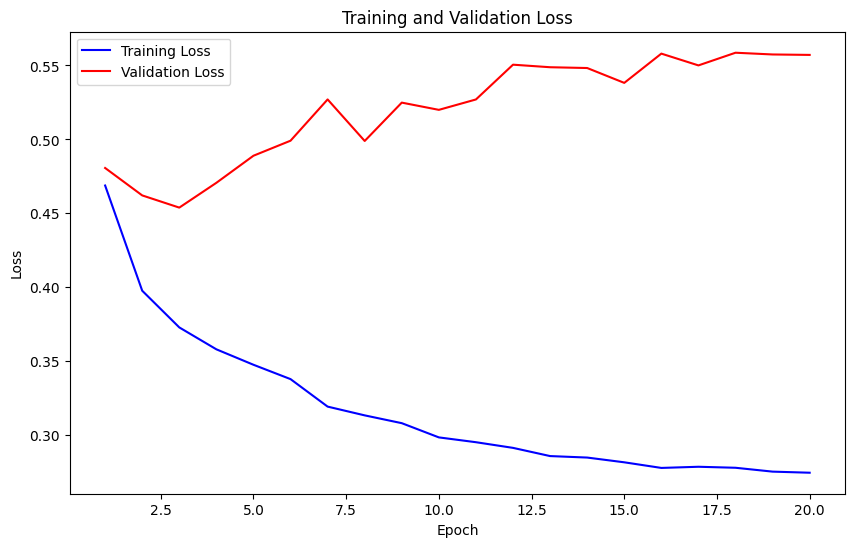

In [17]:
def plot_performance(num_epochs=20):
        epochs = range(1, num_epochs + 1)

        plt.figure(figsize=(10, 6))
        plt.plot(epochs, train_losses, 'b-', label='Training Loss')
        if val_losses:
            plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.show()

plot_performance()

In [18]:
predictions = learner.predict(test_dataset)
predictions

array([ 0.04235682, -0.06443372, -0.06514055, ...,  0.44155404,
        0.27688098,  0.3238784 ], dtype=float32)

In [19]:
df_test_uses_merged['prediction'] = predictions

In [20]:
out_dir = 'answer/'
if not os.path.exists(out_dir):
        os.mkdir(out_dir)
answer_df = df_test_uses_merged[['identifier1', 'identifier2', 'prediction', 'language']]
answer_df = answer_df.reset_index(drop= True)
for i in list(answer_df["language"].value_counts().index):
    df_temp = answer_df[answer_df["language"]==i]
    df_temp = df_temp.drop('language', axis=1)
    df_temp.to_csv('answer/' +i +'.tsv',index = False, sep='\t', quoting=csv.QUOTE_MINIMAL, quotechar='"')

with ZipFile('answer.zip', 'w') as zipf:
    for root, _, files in os.walk(out_dir):
        for file in files:
            zipf.write(os.path.join(root, file), arcname=file)